In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
import requests
url = 'https://enr.electionsfl.org/DAD/2779/Precincts/35849/0/865/'

In [3]:
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
           "(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
r = requests.get(url, headers=headers)

In [4]:
from bs4 import BeautifulSoup as bs

In [5]:
bs_data = bs(r.text, 'html.parser')

In [6]:
precincts_tables = bs_data.findAll('table', {'class': 'DetailResults'})

In [7]:

dataset = pd.DataFrame()

index = 1

# for each precinct
for result in precincts_tables:

    # each row is a candidate
    all_candidate_cols = result.find_all('tr')
    
    new_row = {}
        
    # parse the columns
    for i in range(1, len(all_candidate_cols)):
        candidate_cols = all_candidate_cols[i]

        # parse the columns, one is the name the other is the total votes
        col_values = candidate_cols.find_all('td')

        # each row is a candidate starting from 1

        remove_tags = ['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF']

        # first column is candidate name, remove superfluous white space
        candidate = col_values[0].text
        for tag in remove_tags:
            candidate = candidate.replace('({})'.format(tag), '')
        candidate = candidate.strip()

        # get the vote count (second to last column)        
        votes = int(col_values[-2].text.replace(',', ''))
        new_row[candidate] = votes


    dataset = dataset.append(pd.Series(new_row, name=index))

    index += 1
    

In [8]:
unstacked_data = dataset.unstack().reset_index().rename(
columns={0: 'count', 'level_0': 'candidate', 'level_1': 'index'}
)

In [9]:
unstacked_data.head()

,candidate,index,count
0,Don Blankenship,1,0.0
1,Don Blankenship,2,0.0
2,Don Blankenship,3,0.0
3,Don Blankenship,4,0.0
4,Don Blankenship,5,0.0


Text(0.5, 0.98, 'Miami-Dade Precincts, N=866')

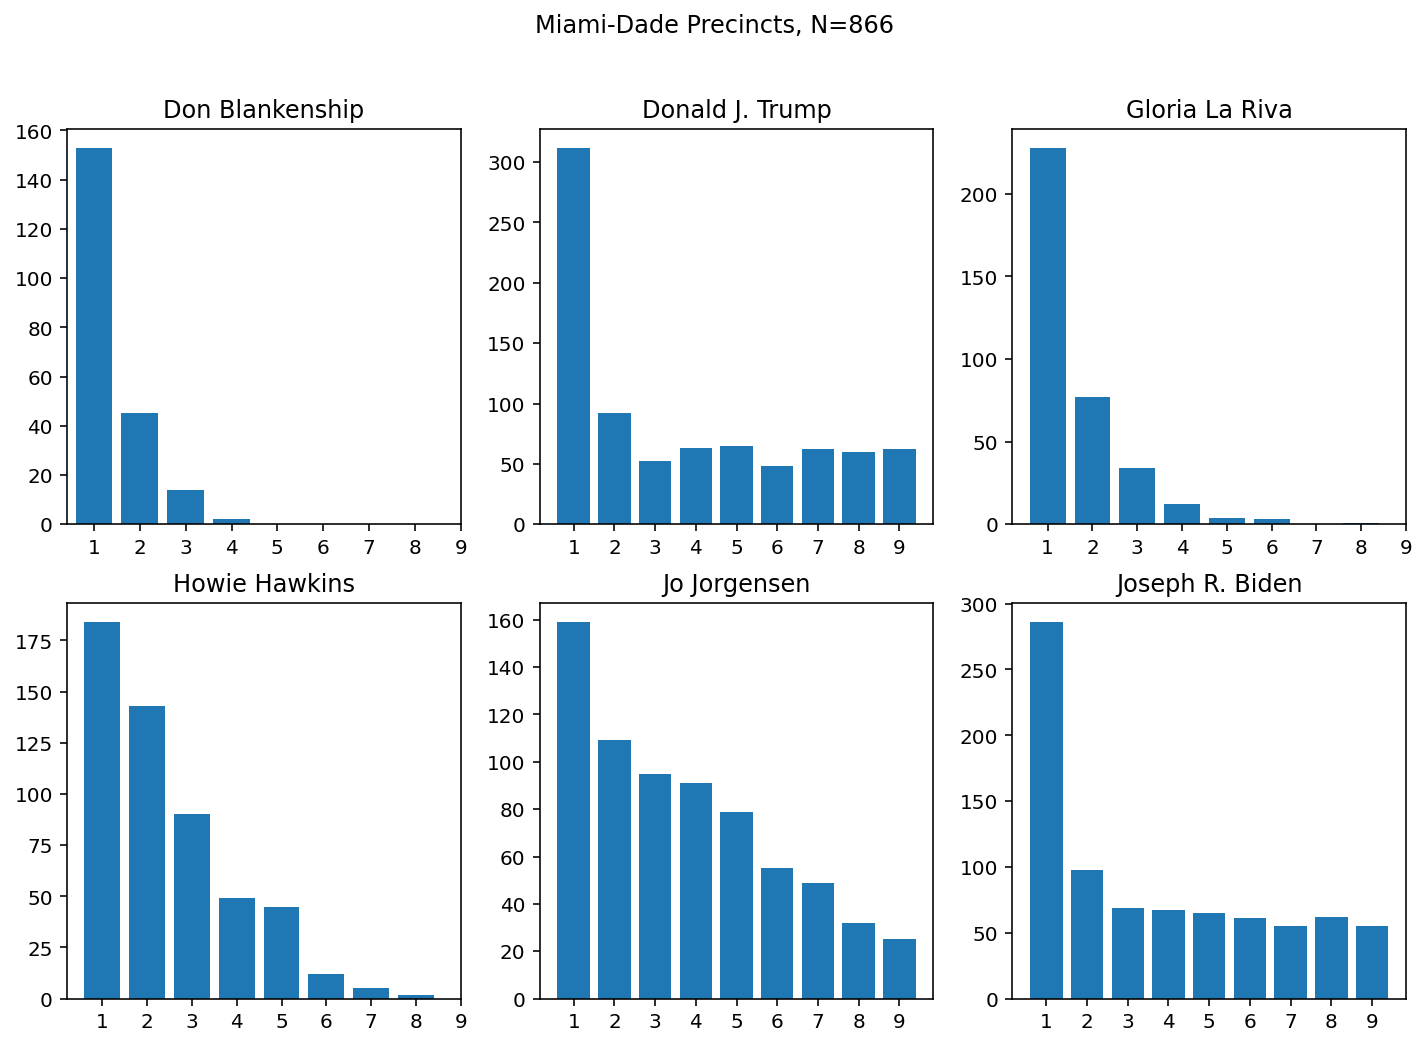

In [11]:

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

for i in range(len(axs)):

    ax = axs[i]
    candidate = candidates[i]
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'index']).sum()
    digits = cur_data.loc[candidate]['count'].astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))

    ax.set_title("%s" % (candidate))

plt.suptitle("Miami-Dade Precincts, N=%d" % len(dataset))
    